In [245]:
'''Import all necessary packages...pandas for data munging, 
sklearn's data preprocessing module, seaborn for data visualization
%matplotlib for making any plots show up inside of this notebook.
joblib for saving models (serialize/deserialize module). We will discuss
each of these packages as we use them for our analysis'''

import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
#from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

In [246]:
#Check the path to the directory where you are currently in
%pwd

'D:\\Information system\\Sem 1\\Info 6105\\Assignment 2'

In [247]:
'''Define a variable that points to this. This will let you avoid typing
the long path everytime you need to use it'''

my_path = 'D:\\Information system\\Sem 1\\Info 6105\\Assignment 2'

# II. Reading data into the notebook

In [248]:
'''We will use the Titanic dataset, as supplied here (Titanic_full.csv).
The same dataset can be downloaded from the Kaggle website. Check the
shape and header of the data you just read in as a dataframe. The use of
f and {} is specific to the recent versions of Python (3.x). You can as 
well type the full path here, and that works too!'''

my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# III. Train - Valid- Test Split

In [249]:
'''As we have seen, it's important to avoid the Texas sharp shooter logical
fallacy. So, we plit the data into three sets in a 70-15-15 manner. 
This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into 
evaluating model performance as you manually change or set the model 
hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). 
This dataset is sometimes called a holdout set or the validation set. 
Finally, the last 15% of the data is the test set.  This dataset is 
never "seen" by the model for model building or hyperparamter tuning. After
hyperparameter tuning and model selection, which we will discuss later,
the model's final performance before sneidng it to production, will be
evalauted on this test data set.
The way the datarows are distributed will depend on the type of problem. 
Here, assuming the datarows of my_df are randomly arranged, and there's
no time component, we will simply simply do the split, using a split 
function that we define. Also, this 15% split 
for the test set may change, if the actual test set size is predefined. 
In any case we will make sure the test set we choose from our dataset 
is as similar as it can get to the actual data that it will see in 
production'''

#Calculate 15% of 1309. This is about 209 rows of data. 
#So, 1309 - 209 = 1100 rows of data will remain for the
#train and valid sets which we will separate later. 200 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1100, 12) (209, 12)


# IV. Data Pre-processing

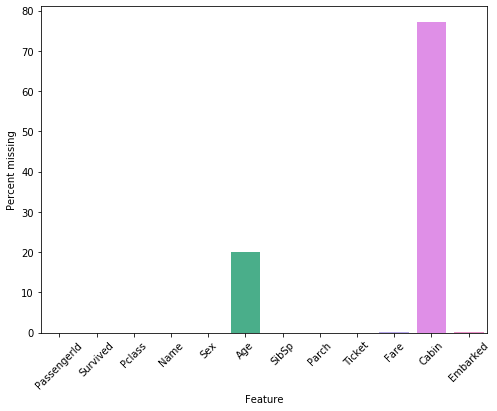

In [250]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

From the above plot, it looks like Cabin has ~80%missing values.
It would be meaningless to impute or fill in 80% values, so we drop the column.
We will impute age (which has ~ 20% missing, but we'll try to impute),
Fare, and Embarked column.These have very little missing values

We are going to preprocess this dataset in these steps--

1. Convert the entire dataframe to an array of numbers. This itself is going to happen in two steps -- (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

2. Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and filling up missing categorical values, we use 0. Also, we add a separate "marker" column for both that notes whether a value has been imputed or not.

3. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.


In [251]:
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [252]:
#Check types of each column with the dataframe info () method
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [253]:
'''You can see that several of the columns or features are "object" type
These need to be changed to category before we can convert those to 
mappings and numbers'''
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [254]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
print()

In [255]:
#Check dtypes of columns after this operation
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [256]:
'''Check the cateogry mapping for Embarked and Sex column. We need this
later'''
print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


All object categories like Name, Sex, and Ticket have been converted to
Category dtype !

In [257]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [258]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [259]:
mydf_train_valid_4.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [260]:
'''Please store the null_table, category mapping separately.
We will need to process the test dataset using these values'''
my_table

{'Age': 28.0, 'Fare': 14.4583}

In [261]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 12) (1100,)


In [262]:
'''Note that the different continuous variable columns of this dataframe 
have numbers in different ranges. For example, the Fare and age columns. 
For some machine learning algorithms like Decision Trees and 
their ensembles (Random Forests, for example) the above X and Y
can be directly used as input. However, for a lot of other ML algorithms 
like K nearest neighbors (KNN), we need to scale the continuous variables 
so that their values are mapped to a number between 0 and 1. 
Let's split this dataframe into continuous variable 
columns and those with categorical variables. We will leave 
the categorical variables untouched because their 
values are treated as different levels and its kind of meaningless to
scale them'''

X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1100, 10) (1100, 2)


In [263]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''

scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [264]:
'''Store this scaler variable or its mean and SD, by pickling or something;
we need to use the same mean and SD scaler later while pre-processing 
the test set. Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [265]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(900, 12) (200, 12) (900,) (200,)


In [266]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

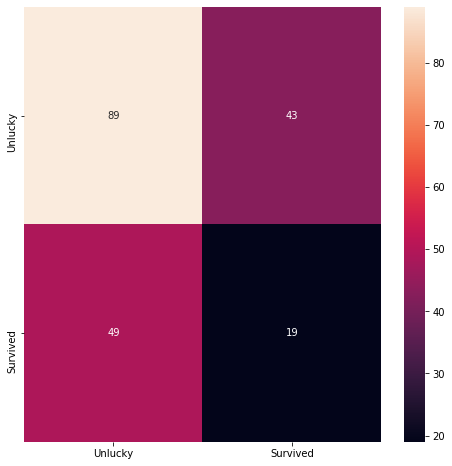

In [267]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [268]:
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

#An MCC of -0.0474 looks bad !We need to do model tuning or 
#hyperparameter tuning to try to make it better

0.54 -0.0474697036788388 0.29230769230769227


# V. Hyperparameter tuning

In [269]:

#Grid search method
#Hyperparameters used: 'algorithm': 'auto', 'n_neighbors': 22, 'weights': 'uniform'

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier()
params = {
    'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_kn = GridSearchCV(estimator = kn,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)
grid_sear= grid_kn.fit(X_train, Y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.9s finished


In [270]:
#Training data set Accuracy score
print(grid_sear.best_params_)
print(grid_sear.best_score_)
print(grid_sear.best_estimator_)

{'algorithm': 'auto', 'n_neighbors': 22, 'weights': 'uniform'}
0.611111111111111
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=22, p=2,
                     weights='uniform')


In [271]:
#Finding the Results
grid_sear_pd=pd.DataFrame(grid_sear.cv_results_)
grid_sear_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012168,0.001164,0.017551,0.003600,auto,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.600000,0.550000,0.583333,0.555556,0.588889,0.575556,0.019437,117
1,0.015955,0.012019,0.005586,0.001197,auto,1,distance,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.600000,0.550000,0.583333,0.555556,0.588889,0.575556,0.019437,117
2,0.007976,0.000630,0.013884,0.002506,auto,2,uniform,"{'algorithm': 'auto', 'n_neighbors': 2, 'weigh...",0.616667,0.572222,0.544444,0.561111,0.561111,0.571111,0.024444,141
3,0.007683,0.000749,0.005395,0.001356,auto,2,distance,"{'algorithm': 'auto', 'n_neighbors': 2, 'weigh...",0.600000,0.550000,0.583333,0.555556,0.588889,0.575556,0.019437,117
4,0.008776,0.001596,0.016957,0.003028,auto,3,uniform,"{'algorithm': 'auto', 'n_neighbors': 3, 'weigh...",0.605556,0.483333,0.533333,0.583333,0.572222,0.555556,0.043033,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.005591,0.000800,0.008400,0.001969,brute,23,distance,"{'algorithm': 'brute', 'n_neighbors': 23, 'wei...",0.572222,0.566667,0.577778,0.627778,0.655556,0.600000,0.035312,41
196,0.005390,0.000495,0.021994,0.009496,brute,24,uniform,"{'algorithm': 'brute', 'n_neighbors': 24, 'wei...",0.572222,0.588889,0.594444,0.644444,0.655556,0.611111,0.032773,1
197,0.005393,0.000788,0.009582,0.001020,brute,24,distance,"{'algorithm': 'brute', 'n_neighbors': 24, 'wei...",0.566667,0.555556,0.566667,0.638889,0.661111,0.597778,0.043404,45
198,0.005593,0.000489,0.016385,0.001008,brute,25,uniform,"{'algorithm': 'brute', 'n_neighbors': 25, 'wei...",0.572222,0.583333,0.577778,0.661111,0.661111,0.611111,0.040976,1


In [272]:
#Fetching the required Column Details
grid_sear_pd_1 = grid_sear_pd[['mean_test_score','param_n_neighbors','param_weights','param_algorithm']]
print(grid_sear_pd_1)

     mean_test_score param_n_neighbors param_weights param_algorithm
0           0.575556                 1       uniform            auto
1           0.575556                 1      distance            auto
2           0.571111                 2       uniform            auto
3           0.575556                 2      distance            auto
4           0.555556                 3       uniform            auto
..               ...               ...           ...             ...
195         0.600000                23      distance           brute
196         0.611111                24       uniform           brute
197         0.597778                24      distance           brute
198         0.611111                25       uniform           brute
199         0.596667                25      distance           brute

[200 rows x 4 columns]


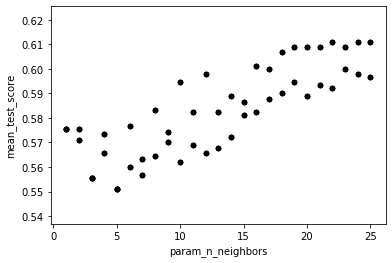

In [273]:
#Plot Training set
import matplotlib.pyplot as plt
import pandas as pd
 
ax = plt.gca()
grid_sear_pd_1 .plot(kind='scatter',x='param_n_neighbors',y='mean_test_score', color='black', ax=ax)

plt.show()

# KNN for validation set

In [274]:
grid_knn_valid = KNeighborsClassifier(algorithm = 'auto' , n_neighbors = 14, weights = 'uniform')
grid_knn_valid.fit(X_train,Y_train)
Y_pred = grid_knn_valid.predict(X_valid)
accuracy_grid_valid = accuracy_score(Y_valid,Y_pred)
print(accuracy_grid_valid)

0.6


# Gradient Boosting for Validation set

In [275]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train,Y_train)
Y_pred1 = gbrt.predict(X_valid)
accuracy_gbrt_valid = accuracy_score(Y_valid,Y_pred)
print(accuracy_gbrt_valid)

0.6


# Random Forest for Validation Set

In [276]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
randf.fit(X_train,Y_train)
y_prd = randf.predict(X_valid)
accuracy_score(Y_valid,y_prd)

0.54

# VI. Evaluating test set accuracy with the trained model

In [277]:
'''Before we can apply this on the test set, we
need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

print(mydf_test.shape)
mydf_test.head(3)


(209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S


In [278]:
#get rid of the "cabin" column as we did before with the train_valid set
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [279]:
'''Make sure the category codes for train and test sets are the same as 
the ones we used previously! Here, we have coded, Name, Sex, Ticket and 
embarked. Because Name and Ticket ids will not be repeated, 
we will check Sex and embarked. Checking category codes for the test set...'''

mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [280]:
#Check for the Embarked column
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [281]:
#Cool, this means the category codes are the same. We can proceed.
#Make sure you use the same impute values of median.
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                         null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [282]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [283]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!


Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [284]:
#Separate continuous and categorical variables/columns for scaling

X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [285]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. Else, save that in a joblib dump too to reload'''

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)


(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [286]:
print(X_cat_t.shape,X_con_sct.shape)

(209, 10) (209, 2)


In [287]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [288]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [289]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

C:\Users\Tharoon\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [290]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [291]:
#Now we are ready to test it out. Let's load the saved model first.
#kNN_loaded = joblib.load(f'{my_path}/knn_model/knn_model_final.sav')

# KNN for Test set

In [292]:
#Testing...
Y_test_pred = grid_knn_valid.predict(X_test_I)

In [293]:
print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.4880382775119617 0.06930075892970221 0.5868725868725868


# Gradient Boosting for Test set

In [294]:
#Testing...
Y_test_pred_gbrt = gbrt.predict(X_test_I)

In [295]:
print(accuracy_score(Y_t,Y_test_pred_gbrt),
      matthews_corrcoef(Y_t,Y_test_pred_gbrt),f1_score(Y_t,Y_test_pred_gbrt))

0.46411483253588515 -0.09554301243453096 0.37078651685393255


# Random Tree Classifier for Test set

In [296]:
Y_test_pred_randf =  randf.predict(X_test_I)

In [297]:
print(accuracy_score(Y_t,Y_test_pred_randf),
      matthews_corrcoef(Y_t,Y_test_pred_randf),f1_score(Y_t,Y_test_pred_randf))

0.4784688995215311 -0.05162950626411216 0.42328042328042326


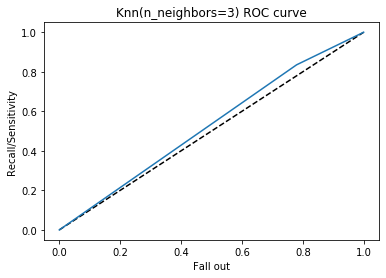

In [298]:
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
rec, fall_out, thresholds = roc_curve(Y_t,Y_test_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(rec,fall_out, label='Knn')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=3) ROC curve')
plt.show()

In [299]:
roc_auc_score(Y_t,Y_test_pred)

0.5277519091078413

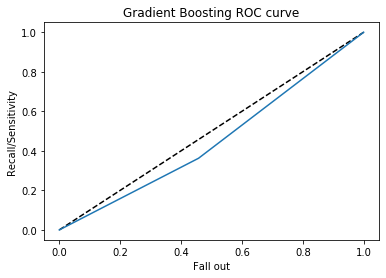

In [300]:
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
rec, fall_out, thresholds = roc_curve(Y_t,Y_test_pred1)
plt.plot([0,1],[0,1],'k--')
plt.plot(rec,fall_out, label='Knn')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Gradient Boosting ROC curve')
plt.show()

In [301]:
roc_auc_score(Y_t,Y_test_pred_gbrt)

0.45250512199664744

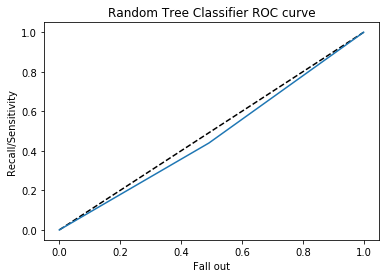

In [302]:
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
rec, fall_out, thresholds = roc_curve(Y_t,Y_test_pred_randf)
plt.plot([0,1],[0,1],'k--')
plt.plot(rec,fall_out, label='Knn')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Random Tree Classifier ROC curve')
plt.show()

In [303]:
roc_auc_score(Y_t,Y_test_pred_randf)

0.474017507915813

Question 2: Briefly describe how gradient boosting differs from bagging. Compare the performance of kNN, random forest classifier and gradient boosting on the Titanic dataset.
Ans:  Bagging:  Bagging is a way to decrease the variance in the prediction by generating additional data for training from dataset using combinations with repetitions to produce multi-sets of the original data. Boosting is an iterative technique which adjusts the weight of an observation based on the last classification. If an observation was classified incorrectly, it tries to increase the weight of this observation.
Gradient boosting is a type of machine learning boosting. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model in order to minimize the error.

Both are ensemble methods which get N learners from additional data from training set. In Bagging any element has the same probability to appear in new data set and the N learners are created Independently.Whereas in Boosting algorithm the element or classifier takes the data based on the success of previous models.

In Bagging the result is obtained by averaging the responses of the N learners (or majority vote). However, Boosting assigns a second set of weights, this time for the N classifiers, in order to take a weighted average of their estimates.


Parameter                    

KNN Classifier,Random Forest,Gradient Boosting

Accuracy Score

0.6,0.6,0.55

Roc_Auc_Score

0.528,0.452,0.465